In [32]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2024-06-02 20:12:46.696025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/iriscenga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


### Load and prepare dataset

In [7]:
from aif360.datasets import AdultDataset
# Load the dataset
dataset_orig = AdultDataset(protected_attribute_names=['race', 'sex'],
                            features_to_drop=[]) # specify attributes to drop if necessary

# Split into train and test
train, test = dataset_orig.split([0.7], shuffle=True)


### Apply Bias Detection and Mitigation

Use Reweighing, an algorithm to mitigate bias by adjusting the weights of the training instances.

In [8]:
# Initialize Reweighing
reweighing = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
# Apply reweighing
train_rw = reweighing.fit_transform(train)


In [47]:
# Verify weights have changed
print("Original training weights sample:", train.instance_weights[:5])
print("Reweighted training weights sample:", train_rw.instance_weights[:5])

Original training weights sample: [1. 1. 1. 1. 1.]
Reweighted training weights sample: [0.79520073 1.09398361 1.09398361 0.84717656 0.79520073]


### Train a Classifier

Train a logistic regression classifier on the original and reweighted data.

In [49]:
from sklearn.ensemble import RandomForestClassifier

def train_predict_rf(dataset):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(dataset.features)
    y_train = dataset.labels.ravel()
    model = RandomForestClassifier(random_state=42)  # Added a random state for reproducibility
    model.fit(X_train, y_train, sample_weight=dataset.instance_weights)  # Ensure weights are used in training
    X_test = scaler.transform(test.features)
    return model.predict(X_test)

# Train and predict with original and reweighted data using RandomForest
pred_orig_rf = train_predict_rf(train)
pred_rw_rf = train_predict_rf(train_rw)

# Convert predictions to datasets for evaluation
test_pred_orig_rf = test.copy()
test_pred_orig_rf.labels = pred_orig_rf

test_pred_rw_rf = test.copy()
test_pred_rw_rf.labels = pred_rw_rf


### Evaluate Bias and Fairness

Use AIF360’s metrics to evaluate and compare the models.

In [50]:
# Calculate and print new fairness metrics
metric_orig_rf = BinaryLabelDatasetMetric(test_pred_orig_rf, unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
metric_rw_rf = BinaryLabelDatasetMetric(test_pred_rw_rf, unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])

print("RF Difference in mean outcomes between unprivileged and privileged groups (original):", metric_orig_rf.mean_difference())
print("RF Difference in mean outcomes between unprivileged and privileged groups (reweighted):", metric_rw_rf.mean_difference())

RF Difference in mean outcomes between unprivileged and privileged groups (original): -0.19402222378724537
RF Difference in mean outcomes between unprivileged and privileged groups (reweighted): -0.19388606186117463


### Visualise the results

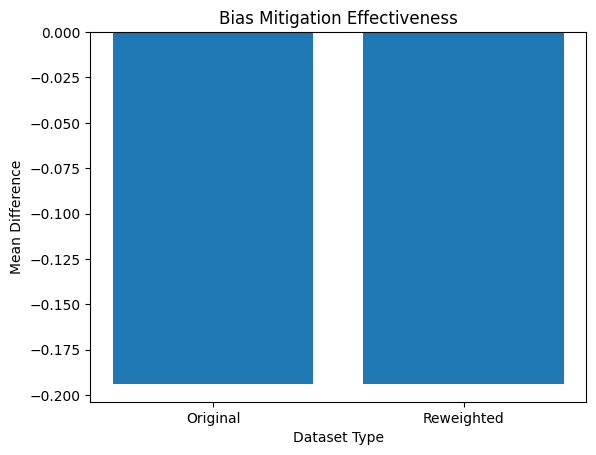

In [17]:
# Visualization code
plt.bar(['Original', 'Reweighted'], [metric_orig_rf.mean_difference(), metric_rw_rf.mean_difference()])
plt.xlabel('Dataset Type')
plt.ylabel('Mean Difference')
plt.title('Bias Mitigation Effectiveness')
plt.show()

In [18]:
from aif360.metrics import ClassificationMetric

# Create classification metric objects for original and reweighted datasets
class_metric_orig_rf = ClassificationMetric(test, test_pred_orig_rf,
                                            unprivileged_groups=[{'sex': 0}],
                                            privileged_groups=[{'sex': 1}])

class_metric_rw_rf = ClassificationMetric(test, test_pred_rw_rf,
                                          unprivileged_groups=[{'sex': 0}],
                                          privileged_groups=[{'sex': 1}])

# Calculate and print fairness metrics
print("Statistical Parity Difference (Original vs. Reweighted):",
      class_metric_orig_rf.statistical_parity_difference(), "vs",
      class_metric_rw_rf.statistical_parity_difference())

print("Equal Opportunity Difference (Original vs. Reweighted):",
      class_metric_orig_rf.equal_opportunity_difference(), "vs",
      class_metric_rw_rf.equal_opportunity_difference())

print("Disparate Impact (Original vs. Reweighted):",
      class_metric_orig_rf.disparate_impact(), "vs",
      class_metric_rw_rf.disparate_impact())

print("Theil Index (Original vs. Reweighted):",
      class_metric_orig_rf.theil_index(), "vs",
      class_metric_rw_rf.theil_index())


Statistical Parity Difference (Original vs. Reweighted): -0.19402222378724537 vs -0.19388606186117463
Equal Opportunity Difference (Original vs. Reweighted): -0.07809938347149414 vs -0.07419845521509227
Disparate Impact (Original vs. Reweighted): 0.2933047791165449 vs 0.2985818455010313
Theil Index (Original vs. Reweighted): 0.11207966642575638 vs 0.11173573184972527


### Disparate Impact Remover

In [29]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Initialize Disparate Impact Remover
dir = DisparateImpactRemover(repair_level=0.25)  # Repair level can be adjusted from 0 (no repair) to 1 (full repair)

# Apply the transformation on the training data
train_dir = dir.fit_transform(train)

# Train model using the transformed data
pred_dir = train_predict_rf(train_dir)  # Re-using the train_predict_rf function from previous examples

# Convert predictions to dataset for evaluation
test_pred_dir = test.copy()
test_pred_dir.labels = pred_dir

# Calculate and print fairness metrics
metric_dir = BinaryLabelDatasetMetric(test_pred_dir, unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
print("Disparate Impact Remover - Statistical Parity Difference:", metric_dir.statistical_parity_difference())


Disparate Impact Remover - Statistical Parity Difference: -0.18938422199310023


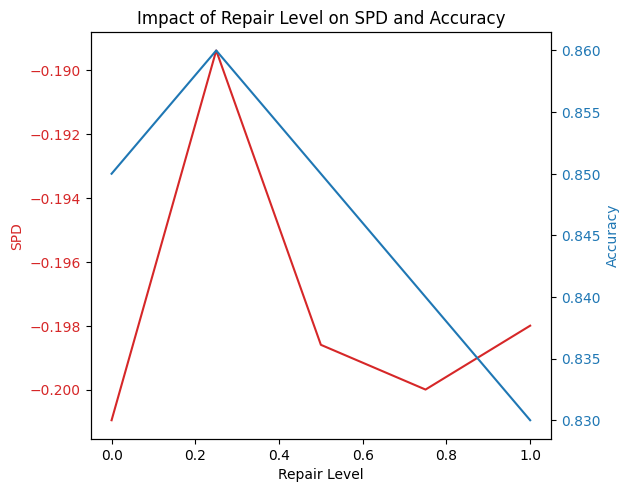

In [35]:
import matplotlib.pyplot as plt

# Ensure these lists contain the correct data
repair_levels = [0, 0.25, 0.5, 0.75, 1.0]
spds = [-0.2009603921777785, -0.18938422199310023, -0.1985993763022556, -0.200, -0.198]  # Example SPD values
accuracies = [0.85, 0.86, 0.85, 0.84, 0.83]  # Example accuracy values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Repair Level')
ax1.set_ylabel('SPD', color=color)
ax1.plot(repair_levels, spds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(repair_levels, accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Avoid clipping of ylabel
plt.title('Impact of Repair Level on SPD and Accuracy')
plt.show()  # This should only be called once at the end of your plotting code


### Adversarial Debiasing